<a href="https://colab.research.google.com/github/saeedabi1/Deep_Learning_CMPE_258/blob/master/Mirsaeid_Abolghasemi_Graded_Assignment_1_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mirsaeid Abolghasemi - Deep LEarning 258**

Graded Assignment 1 : Do MNIST classifier using numpy and python without CNN and just using plain neural networks. From scratch. 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [2]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
#Build Neural Network from scratch with Numpy on MNIST Dataset


In [0]:

#from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [0]:
# import
# implement MNIST classifier 
mnist = fetch_openml('mnist_784')
#mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]

In [0]:
#f) The code should normalize the input as discussed in the class 
#before training (scaling the input)
# scale
# Normalize the data
X = X / 255

In [0]:
# each image has to 3D: 2 coordinates, 1 value (gray scale)
# one-hot encode labels
digits = 10
examples = y.shape[0]
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

In [0]:
# split, reshape, shuffle
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

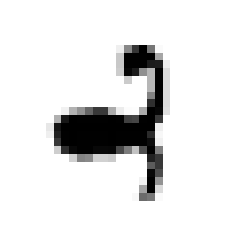

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

i = 3
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
#print(y_train[:,i])

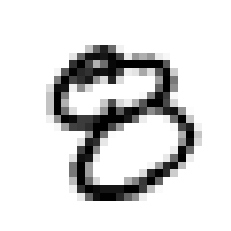

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [10]:
i = 12
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
Y_train[:,i]

In [11]:

print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train",Y_train.shape)
print("y_test:",Y_test.shape)


X_train: (784, 60000)
X_test: (784, 10000)
y_train (10, 60000)
y_test: (10, 10000)


***Relu activation function***

In [0]:
def relu(x):
  y = np.copy(x)
  y[y<0] = 0
  return y

***Derivative of Relu activation function***

In [0]:
def relu_diff(x):
  y = np.copy(x)
  y[y>=0] = 1
  y[y<0] = 0
  return y


**Loss function**

In [0]:
def compute_loss(Y, Y_hat):
    """
    compute loss function
    """
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

**Feed Forward**

In [0]:
def feed_forward(X, params):
    """
    feed forward network: 2 - layer neural net

    inputs:
        params: dictionay a dictionary contains all the weights and biases

    return:
        cache: dictionay a dictionary contains all the fully connected units and activations
    """
    cache = {}

    # Z1 = W1.dot(x) + b1
    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]

    # A1 = sigmoid(Z1)
    #cache["A1"] = sigmoid(cache["Z1"])

    # A1 = relu(Z1)
    cache["A1"] = relu(cache["Z1"])

    # Z2 = W2.dot(A1) + b2
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]

    # A2 = softmax(Z2)
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache




**Back Propagation**

In [0]:


def back_propagate(X, Y, params, cache):
    """
    back propagation

    inputs:
        params: dictionay a dictionary contains all the weights and biases
        cache: dictionay a dictionary contains all the fully connected units and activations

    return:
        grads: dictionay a dictionary contains the gradients of corresponding weights and biases
    """
    # error at last layer
    dZ2 = cache["A2"] - Y
        
    # gradients at last layer (Py2 need 1. to transform to float)
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    # back propgate through first layer
    dA1 = np.matmul(params["W2"].T, dZ2)
    #dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dZ1 = dA1 * relu_diff(cache["Z1"])

    # gradients at first layer (Py2 need 1. to transform to float)
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

**Weight Initialization**

Current recommendation  for RELU:  variance of neurons in the network should be  2.0/n

For relu : w = np.random.randn(n) * sqrt(2.0/n)


In [0]:
np.random.seed(138)

# hyperparameters
n_x = X_train.shape[0]
n_h = 64

In [0]:
# initialization
#b-2: The code should initialize the random weights of network properly
#to initialize the random weights before training
params = { "W1": np.random.randn(n_h, n_x) * np.sqrt(2. / n_x),
           "b1": np.zeros((n_h, 1)) * np.sqrt(2. / n_x),
           "W2": np.random.randn(digits, n_h) * np.sqrt(2. / n_h),
           "b2": np.zeros((digits, 1)) * np.sqrt(2. / n_h) }

V_dW1 = np.zeros(params["W1"].shape)
V_db1 = np.zeros(params["b1"].shape)
V_dW2 = np.zeros(params["W2"].shape)
V_db2 = np.zeros(params["b2"].shape)

**Training**

the hyper-parameters are tuned are learning rate, training epochs and batch size

In [0]:

learning_rate = 4
beta = .9
#pick appropriate batch size for minibatch
batch_size = 128
batches = -(-m // batch_size)

In [20]:
#a) The code should do mini batch gradient descent along 
#with appropriate learning rate
#mini-batch gradient descent
# train
for i in range(9):

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    for j in range(batches):

        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache)

        #adding momentum
        V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])
        V_db1 = (beta * V_db1 + (1. - beta) * grads["db1"])
        V_dW2 = (beta * V_dW2 + (1. - beta) * grads["dW2"])
        V_db2 = (beta * V_db2 + (1. - beta) * grads["db2"])

        params["W1"] = params["W1"] - learning_rate * V_dW1
        params["b1"] = params["b1"] - learning_rate * V_db1
        params["W2"] = params["W2"] - learning_rate * V_dW2
        params["b2"] = params["b2"] - learning_rate * V_db2

    cache = feed_forward(X_train, params)
    train_cost = compute_loss(Y_train, cache["A2"])
    cache = feed_forward(X_test, params)
    test_cost = compute_loss(Y_test, cache["A2"])
    print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

print("Done.")

Epoch 1: training cost = 0.2405273247905295, test cost = 0.2537536189929961
Epoch 2: training cost = 0.2141663551431868, test cost = 0.22546168395682117
Epoch 3: training cost = 0.16574390211008252, test cost = 0.213444185405167
Epoch 4: training cost = 0.17749469174128862, test cost = 0.23385219134945562
Epoch 5: training cost = 0.16180151221545397, test cost = 0.24647660776441885
Epoch 6: training cost = 0.1360829827131235, test cost = 0.2188108809917425
Epoch 7: training cost = 0.11797512504229209, test cost = 0.20462041184430535
Epoch 8: training cost = 0.113582518786939, test cost = 0.2089189622113701
Epoch 9: training cost = 0.11168638994628212, test cost = 0.20439442658107873
Done.


**Results**

In [21]:
cache = feed_forward(X_test, params)
predictions = np.argmax(cache["A2"], axis=0)
labels = np.argmax(Y_test, axis=0)

print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       954
           1       0.98      0.99      0.98      1124
           2       0.95      0.96      0.96      1027
           3       0.96      0.91      0.93      1072
           4       0.96      0.94      0.95      1000
           5       0.91      0.97      0.94       832
           6       0.97      0.95      0.96       978
           7       0.96      0.97      0.97      1018
           8       0.96      0.90      0.93      1041
           9       0.92      0.97      0.95       954

    accuracy                           0.96     10000
   macro avg       0.95      0.96      0.95     10000
weighted avg       0.96      0.96      0.96     10000



**confusion_matrix**

In [22]:
print(confusion_matrix(predictions, labels))

[[ 941    0    2    0    1    2    4    1    0    3]
 [   1 1111    0    0    1    0    2    3    1    5]
 [   1    3  984   10    5    1    0   18    5    0]
 [   2    4    7  973    1   51    2    4    9   19]
 [   2    0    4    1  945    1    4    5    7   31]
 [   3    1    1    3    0  809    6    0    5    4]
 [  12    2    9    1    8   10  932    0    3    1]
 [   6    0    8    4    3    1    0  990    2    4]
 [  12   14   17   18    4   14    8    3  939   12]
 [   0    0    0    0   14    3    0    4    3  930]]


**MNIST classifier using numpy and python, Keras and just using MLP.**

In [0]:
from keras.datasets import mnist
from keras.optimizers import SGD
# Standardize images across the dataset, mean=0, stdev=1
from keras.preprocessing.image import ImageDataGenerator
# Plot images
from matplotlib import pyplot

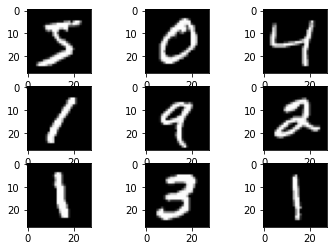

In [24]:

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

**Image Augmentation using Keras**

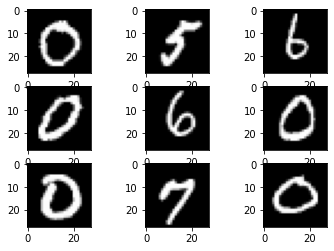

In [25]:

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


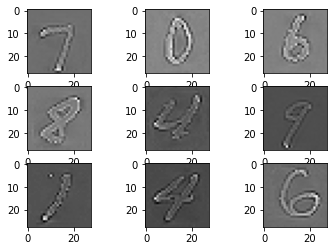

In [26]:
# define data preparation by using ZCA Whitening
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

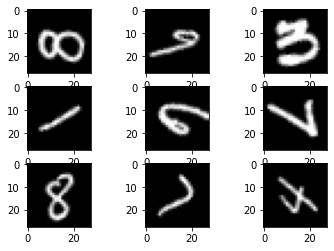

In [27]:
#random rotation
datagen = ImageDataGenerator(rotation_range=90)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

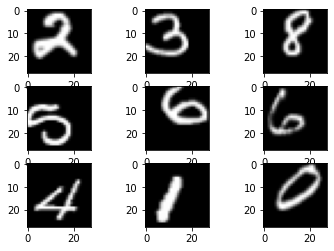

In [28]:
# define data preparation by random shift
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

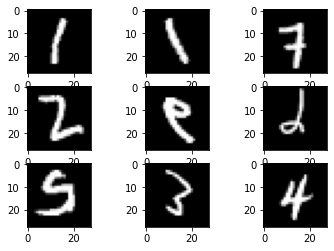

In [29]:
# define data preparation by random horizontal and vertical flip
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

In [0]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

In [0]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [0]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

**Creating model with Multi-Layer Perceptrons (MLP) and dropout**




**Configure the Learning Rate in Keras based on Stochastic Gradient Descent - Adaptive Learning Rate Gradient Descent**

# **Effect of Adaptive Learning Rates**

**g) The code should use appropriate learning rate (try out few to find out which one works) - you can use adaptive learning rates like different learning rates per epoch or per mini batch -**

Running the example creates a single figure that contains four line plots for the different evaluated optimization algorithms. 

**Classification accuracy on the training dataset is marked in blue, whereas accuracy on the test dataset is marked in orange.**

In [34]:
import numpy as np
import matplotlib.pyplot as plt
# define create_model 

  # create model
model = Sequential()
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

#X_train = X_train.astype(np.float)
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adam']

#X_train = list([list(x) for x in X_train])


for opt in optimizers:
  # determine the plot number
  #plot_no = 220 + (i+1)
  #pyplot.subplot(plot_no)


  print('\nAdaptive learning rate methods= '+opt)
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # Fit the model
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

  # Final evaluation of the model
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("\nBaseline Error: %.2f%%\n" % (100-scores[1]*100))

  # plot learning curves
  #pyplot.plot(history.history['acc'], label='train')
  #pyplot.plot(history.history['val_acc'], label='test')
  #pyplot.title('\nAdaptive learning rate methods= '+opt, pad=-80)

  
  # show learning curves
  #pyplot.show()
  #print("Blue= Classification accuracy")
  #print("Orange= Accuracy on the test dataset")
  
  print("\n Confusion Matrix: ")

  y_pred = model.predict(X_test)
  y_test = y_test.reshape(10000,10)
  rounded_predictions = model.predict_classes(X_test, batch_size=128, verbose=0)
  rounded_labels=np.argmax(y_test, axis=1)
  cm = confusion_matrix(rounded_labels, rounded_predictions)
  print(cm)
  print("\n"+ "*"*100 + "\n")






Adaptive learning rate methods= sgd
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 0.9011 - acc: 0.7587 - val_loss: 0.3866 - val_acc: 0.8959
Epoch 2/10
 - 2s - loss: 0.3712 - acc: 0.8943 - val_loss: 0.2888 - val_acc: 0.9180
Epoch 3/10
 - 2s - loss: 0.2941 - acc: 0.9151 - val_loss: 0.2482 - val_acc: 0.9286
Epoch 4/10
 - 2s - loss: 0.2551 - acc: 0.9262 - val_loss: 0.2207 - val_acc: 0.9359
Epoch 5/10
 - 2s - loss: 0.2263 - acc: 0.9355 - val_loss: 0.2020 - val_acc: 0.9403
Epoch 6/10
 - 2s - loss: 0.2068 - acc: 0.9400 - val_loss: 0.1859 - val_acc: 0.9437
Epoch 7/10
 - 2s - loss: 0.1895 - acc: 0.9451 - val_loss: 0.1739 - val_acc: 0.9482
Epoch 8/10
 - 2s - loss: 0.1766 - acc: 0.9491 - val_loss: 0.1613 - val_acc: 0.9519
Epoch 9/10
 - 2s - loss: 0.1639 - acc: 0.9522 - val_loss: 0.1538 - val_acc: 0.9528
Epoch 10/10
 - 2s - loss: 0.1529 - acc: 0.9560 - val_loss: 0.1453 - val_acc: 0.9561

Baseline Error: 4.39%


 Confusion Matrix: 
[[ 965    0    1    2    1    4    3 